In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from Selector import Selector
from Tablecreator import TableCreator
from Inserter import Inserter

# DB CREATION AND INSERT

In [2]:
def _exec(DB, statement):
    DB.c.execute(statement)


def createDB(DB_name):
    testDB = TableCreator(DB_name)
    testDB.createArticle()
    testDB.createAuthor()
    testDB.createHas()
    testDB.createCitation()
    testDB.closeConnect()
    return

name = 'test.db'
createDB(name)

In [3]:
def insert_paper(DB_name, idd, article, authors, year, citations = '', citated = '', keywords = '', pages = '', volume = '', issue = '', abstract = ''):
    testDB = Inserter(DB_name)
    if testDB.insertArticle(idd, article, keywords, pages, year, volume, issue, abstract):
        for author in authors:
            testDB.insertAuthor(author)
            testDB.insertHas(idd, author)

        for cit in citations:
            testDB.insertCitations(idd, cit)
        for cit in citated:
            testDB.insertCitations(cit, idd)
        testDB.closeConnect()
    return

# Parsing DATA

In [4]:
# pip install elsapy

from elsapy.elsclient import ElsClient
from elsapy.elsprofile import ElsAuthor, ElsAffil
from elsapy.elsdoc import FullDoc, AbsDoc
from elsapy.elssearch import ElsSearch
import json
import requests

## Debug imports
from time import time
    
## Load configuration
con_file = open("config.json")
config = json.load(con_file)
con_file.close()

## Initialize client
client = ElsClient(config['apikey'])

In [5]:
def search(name, numres):
    res = []
    if numres != -1:
        return defsearch(numres, name)
    else:
        body = {
            "authors": name,
            "loadedAfter": "2010-01-01T00:00:00Z",
            "display": {
                "show": 1
            }
        }
        r = requests.put(base, data=json.dumps(body), headers=headers).json()
        return defsearch(r['resultsFound'], name)



def defsearch(numres, name):
    print('Found ' + str(numres) + ' results')
    base = 'https://api.elsevier.com/content/search/sciencedirect'
    headers = {
        'x-els-apikey': config['apikey'],
        'Content-Type': 'application/json'
    }
    res = []
    for offset in range(0, numres, 100):
            body = {
                "authors": name,
                "loadedAfter": "2010-01-01T00:00:00Z",
                "display": {
                    "offset": offset,
                    "show": min(100, numres - offset)
                }
            }
            r = requests.put(base, data=json.dumps(
                body), headers=headers).json()
            res += r['results']
    return res

# Insert ifo to DB

In [6]:
def push_info_to_db(searchres, name = 'test.db'):
    for elem in searchres:
        idd = elem['pii']
        article = elem['sourceTitle']
        auths = [author['name'] for author in elem['authors']]
        year = int(elem['publicationDate'][:4])
        insert_paper(name, idd, article, auths, year)

In [7]:
from random import randint
from queue import Queue

q = Queue()

# get random search result
s = search('Markov', 1)
push_info_to_db(s)

# put first authors in the queue
for auth in s[0]['authors']:
    q.put(auth['name'])
    
# search co-authors in queue
threshold = 150
i = 0
while not q.empty() and i <= threshold:
    searchres = search(q.get_nowait(), randint(5, 10))
    push_info_to_db(searchres)
    for res in searchres:
        for author in res['authors']:
            q.put(author['name'])
    i += 1

Found 1 results
Found 6 results
Found 10 results
Found 6 results
Found 8 results
Found 6 results
Found 10 results
Found 5 results
Found 6 results
Found 5 results
Found 9 results
Found 6 results
Found 6 results
Found 6 results
Found 7 results
Found 6 results
Found 10 results
Found 7 results
Found 10 results
Found 9 results
Found 5 results
Found 6 results
Found 7 results
Found 6 results
Found 10 results
Found 5 results
Found 9 results
Found 7 results
Found 7 results
Found 10 results
Found 6 results
Found 7 results
Found 6 results
Found 7 results
Found 5 results
Found 6 results
Found 6 results
Found 10 results
Found 5 results
Found 5 results
Found 7 results
Found 5 results
Found 5 results
Found 5 results
Found 7 results
Found 8 results
Found 10 results
Found 9 results
Found 8 results
Found 7 results
Found 5 results
Found 5 results
Found 7 results
Found 10 results
Found 6 results
Found 8 results
Found 6 results
Found 5 results
Found 6 results
Found 5 results
Found 7 results
Found 7 results

# Make Authors Graph

In [8]:
def create_df_authors(DB_name):
    testDB = Selector(DB_name)
    df = testDB.make_df_authors()
    testDB.closeConnect()
    return df

In [9]:
def create_df_authors_for_year(DB_name, year):
    testDB = Selector(DB_name)
    df = testDB.make_df_for_year(year)
    testDB.closeConnect()
    return df

In [10]:
def create_graph_from_pandas_df(df):
    """ Takes pandas dataframe and create networkx graph. We suggest every row in df
        is an article with next columns: 'list of authors' (list of strings)
    """
    G = nx.Graph()
    
    for num, row in df.iterrows():
        authors_list = row['authors_list']
        # connect every one and update edges
        for i in range(len(authors_list)):
            for j in range(i + 1, len(authors_list)):
                from_, to_ = authors_list[i], authors_list[j]
                new_weight = (G[from_][to_]['weight'] if G.has_edge(from_, to_) else 0) + 1
                G.add_edge(from_, to_, weight=new_weight)
        
    return G    

In [15]:
name = 'test.db'
df = create_df_authors_for_year(name, 2011)
df = df.append(create_df_authors_for_year(name, 2010))
G = create_graph_from_pandas_df(df)

In [54]:
len(list(Gc.adjacency()))

53

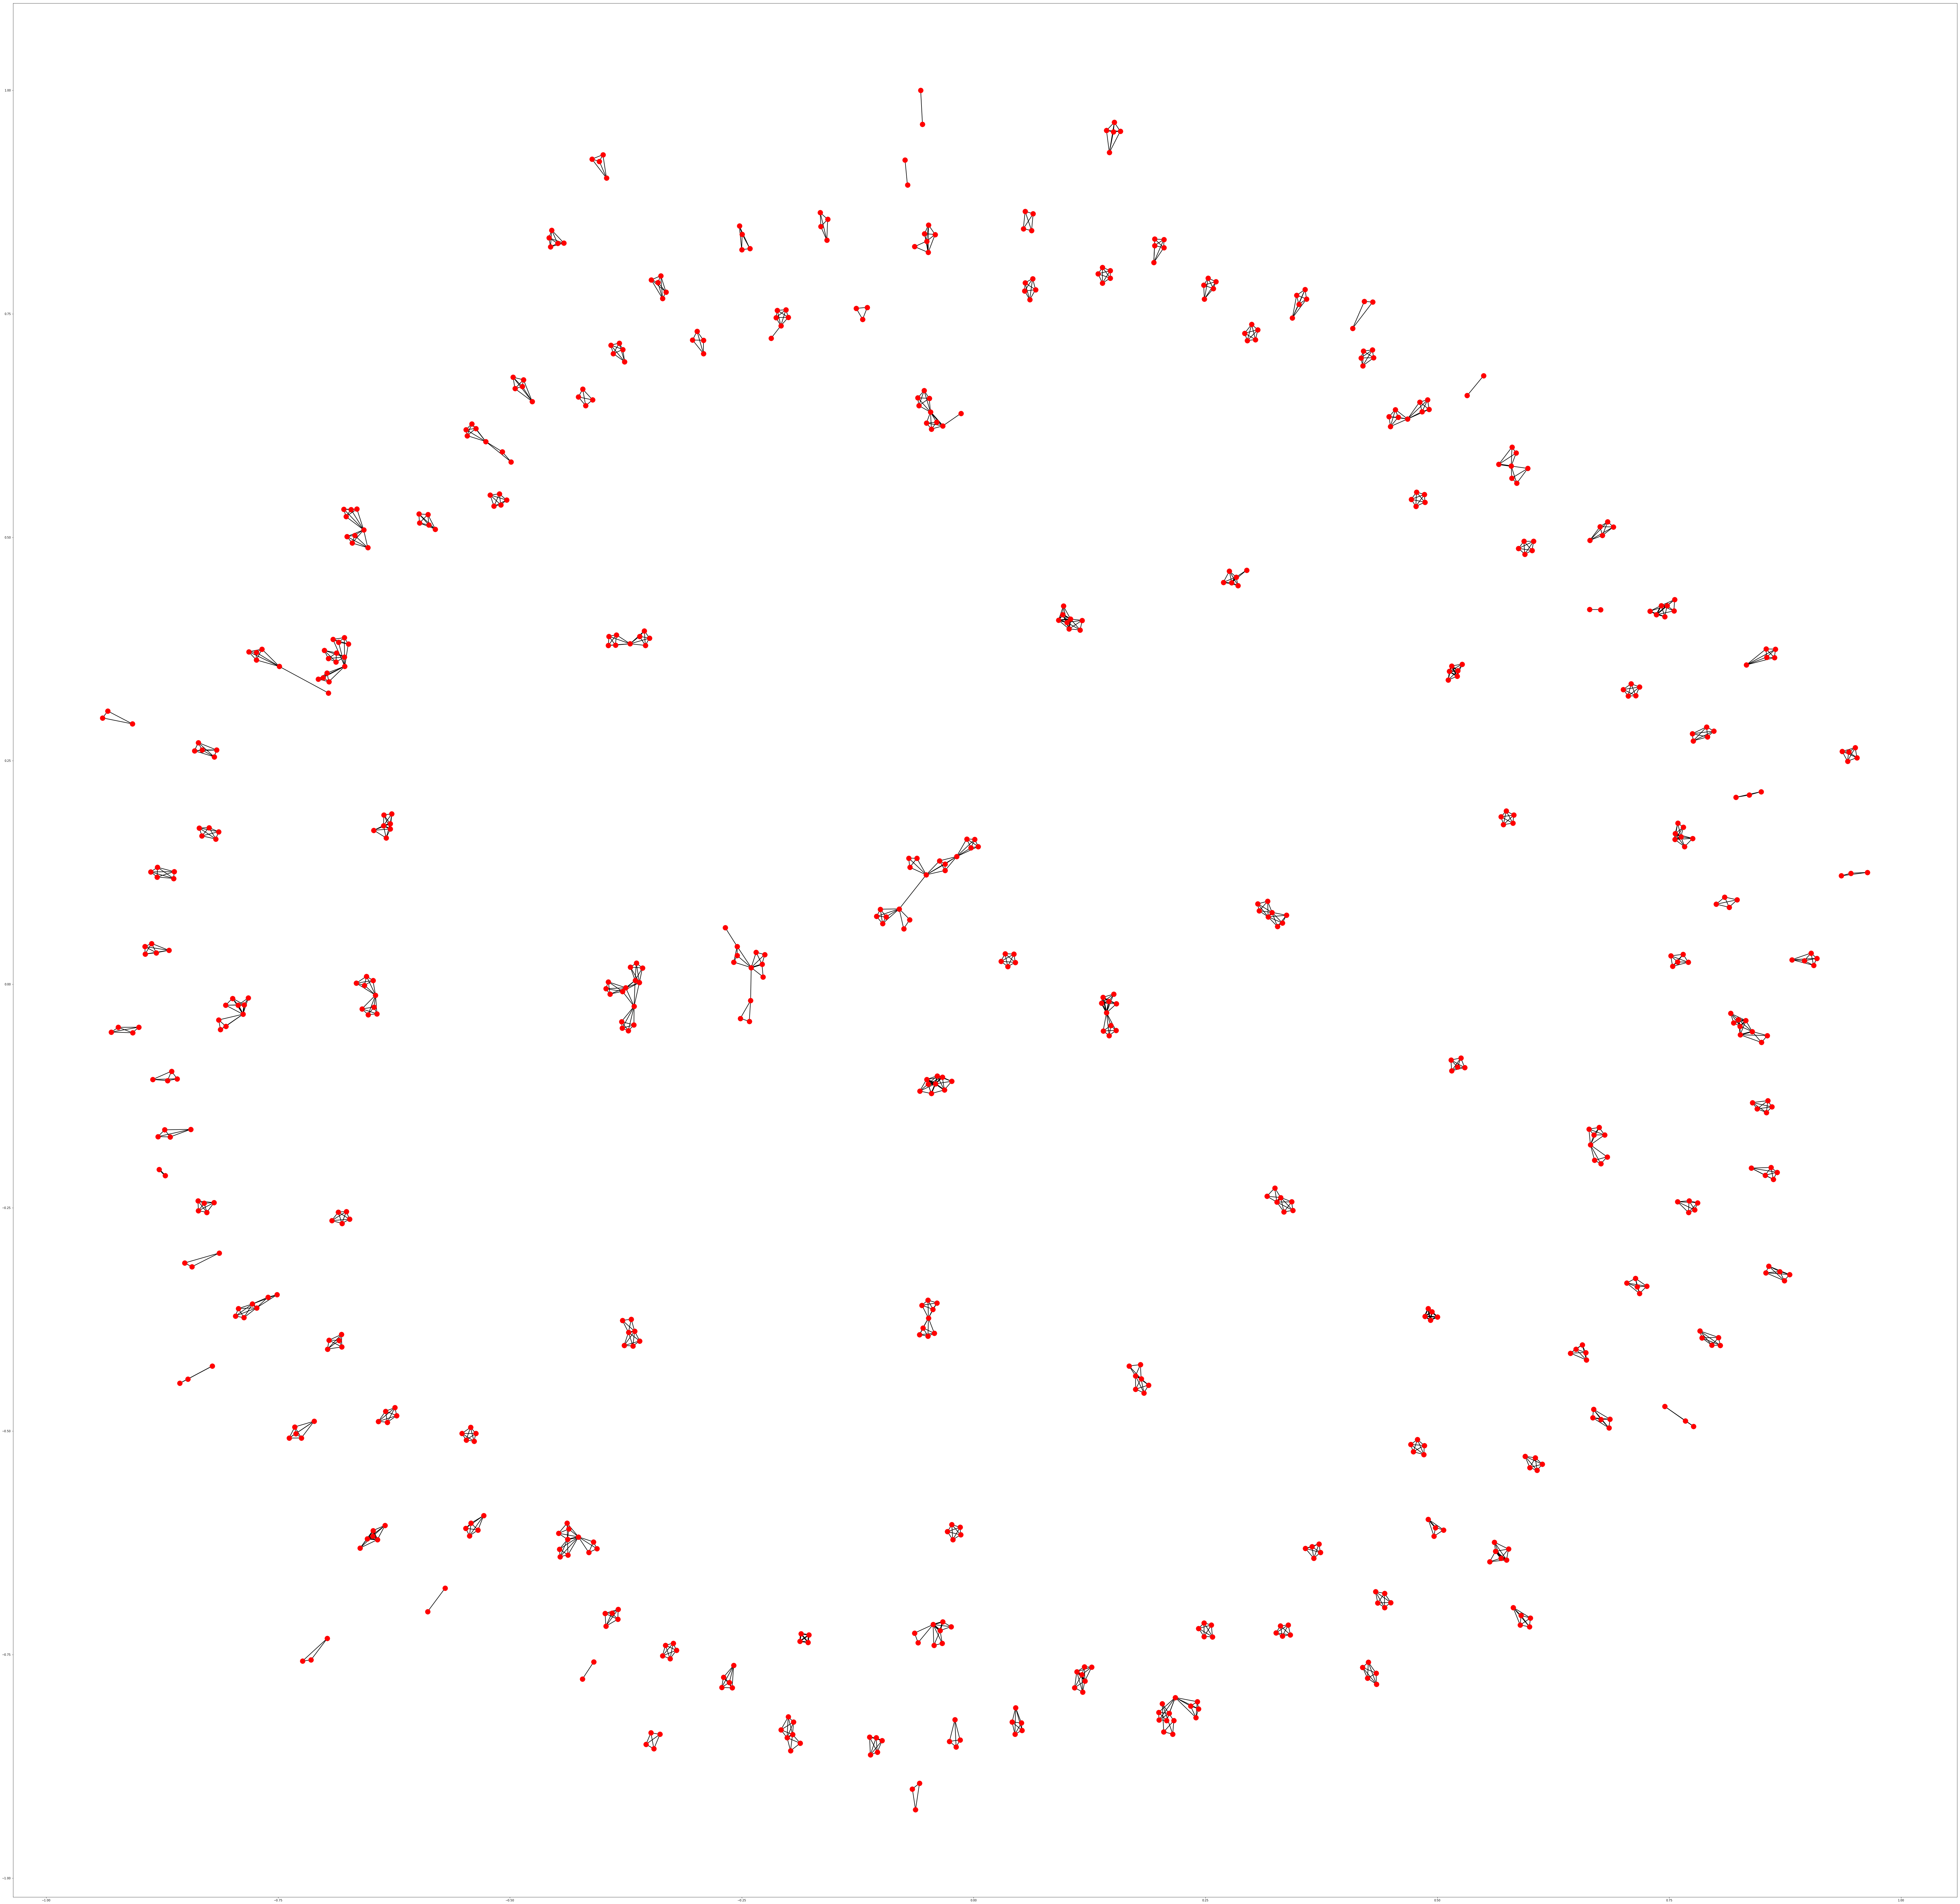

In [17]:
plt.figure(figsize=(120, 120))

labels = nx.get_edge_attributes(G,'weight')

layout = nx.spring_layout(G)
weights = nx.get_edge_attributes(G,'weight')

widths = [weights[i]*2 for i in G.edges()]

# nx.draw(G, with_labels=True, font_weight='bold')
#nx.draw_networkx_labels(G, font_size=20, pos=layout)
nx.draw_networkx_edges(G, pos=layout, width=widths)
nx.draw_networkx_nodes(G, pos=layout)

Создание подграфа из 50 вершин путем откидывания компонент связанности

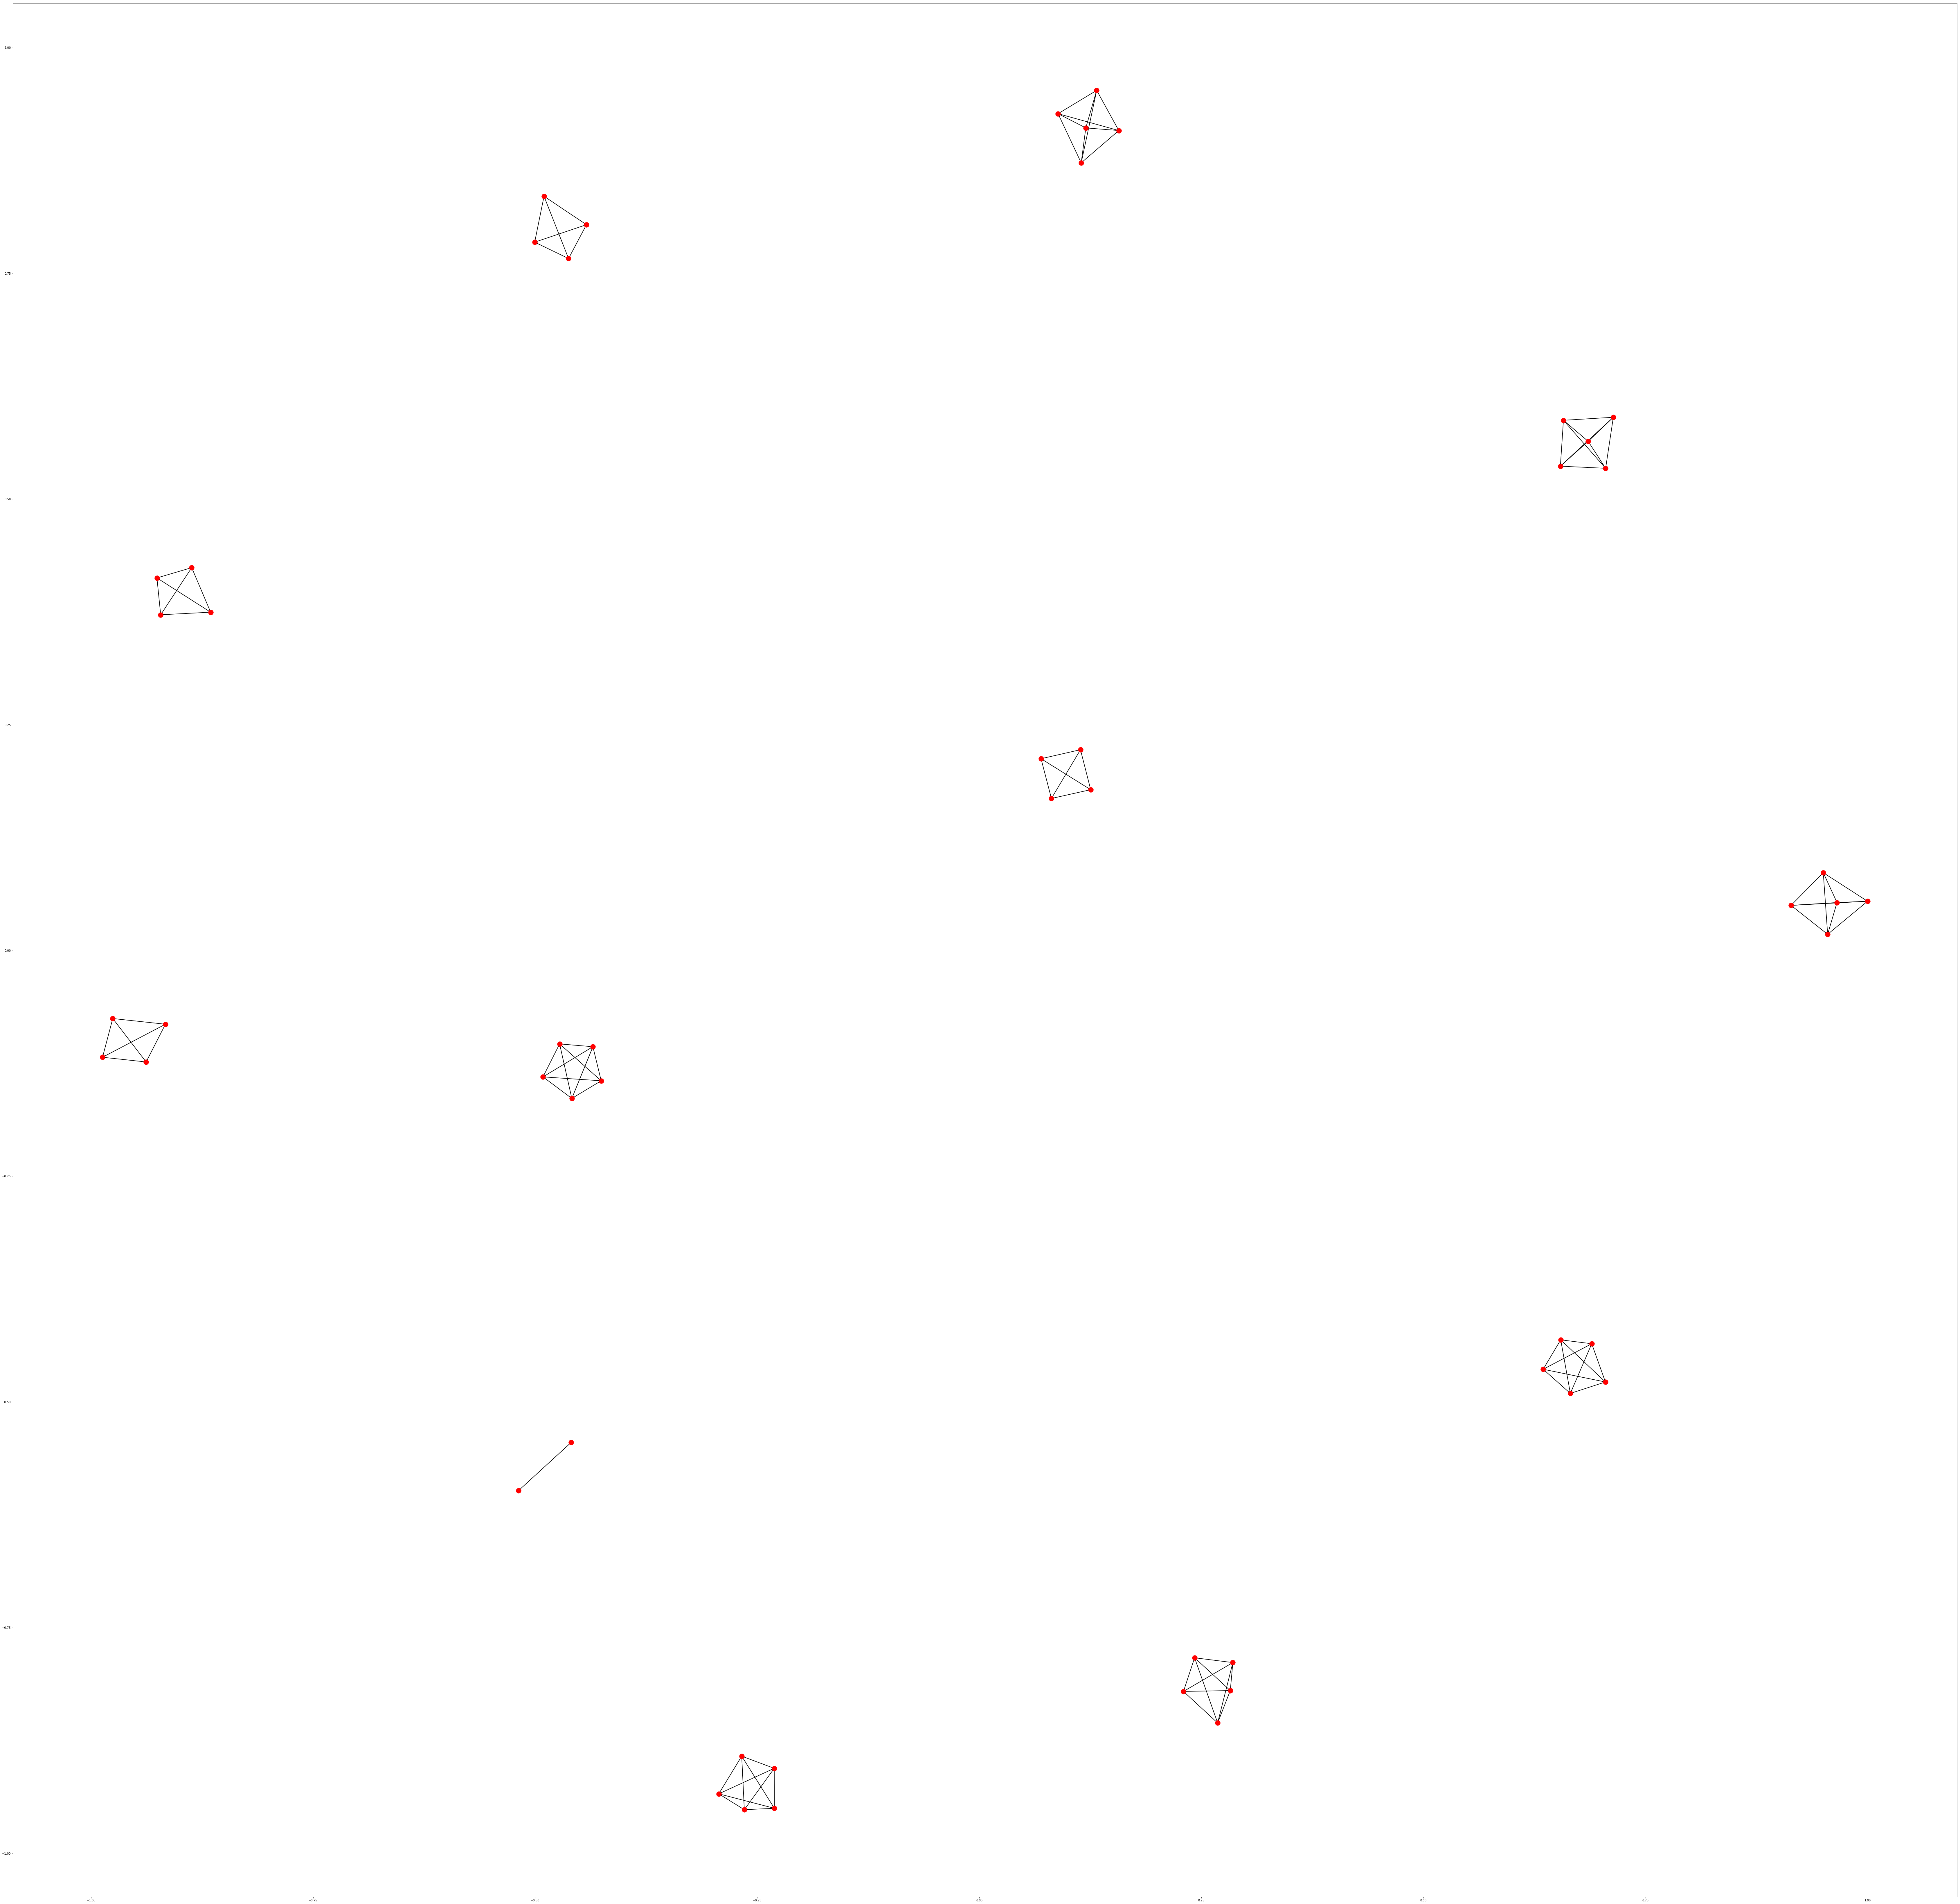

In [51]:
Gc = nx.Graph()
for i in list(nx.connected_component_subgraphs(G))[::-1]:
    Gc = nx.union(Gc, i)
    if(len(list(Gc.adjacency())) >= 50):
        break

plt.figure(figsize=(120, 120))

labels = nx.get_edge_attributes(Gc,'weight')

layout = nx.spring_layout(Gc)
weights = nx.get_edge_attributes(Gc,'weight')

widths = [weights[i]*2 for i in Gc.edges()]

# nx.draw(G, with_labels=True, font_weight='bold')
#nx.draw_networkx_labels(G, font_size=20, pos=layout)
nx.draw_networkx_edges(Gc, pos=layout, width=widths)
nx.draw_networkx_nodes(Gc, pos=layout)

In [41]:
InfecProbPer1, Infected = 0.1, 0.1

newGr = nx.Graph()
newGr = nx.union(newGr, Gc)

In [42]:
money = 0

In [26]:
def randfloat():
    return randint(0, 9223372036854775807) / 9223372036854775807

In [43]:
sost = {}
from random import *
for i in list(newGr.nodes()):
    if(randfloat() <= Infected):
        sost[i] = randint(3, 7)
    else:
        sost[i] = 0


In [44]:
fl = True

while fl:
    fl = False
    newGr1 = nx.Graph()
    for i in newGr.nodes:
        newGr1.add_node(i)
    for i in newGr.edges:
        if(randfloat() >= (1 - InfecProbPer1) ** newGr.edges[i]['weight']):
            newGr1.add_edge(i[0], i[1])
    for i in newGr.nodes:
        if(sost[i] == 0):
            for j in newGr.nodes:
                if((not sost[j] == 0) and nx.has_path(newGr1, j, i)):
                    sost[i] = randint(3, 7)
                    break
    fordel = []
    for i in newGr.nodes:
        if(sost[i] >= 0):
            money += 120
            sost[i] -= 1
            if(sost[i] == 0):
                fordel.append(i)
            else:
                fl = True
    for i in fordel:
        newGr.remove_node(i)
    break

In [45]:
money

6960

In [31]:
newGr.edges['Monika Kovačević', 'Lidija Barišić']['weight']

1

Две функции:
setup, которая задает начальные вероятности и графы
punchline которая симулирует заражение(каждый тик вычисляются незаблокированные ребра и вычисляются зараженные, после вычисляются выздоровевшие) и подсчитывает затраты
Между их вызовами происходит стратегия вакцинации(вакцинируем мы в начале перед заражением)

In [77]:
def setup(a, b):
    global InfecProbPer1
    global Infected
    global newGr
    global sost
    global money
    InfecProbPer1, Infected = a, b
    newGr = nx.Graph()
    newGr = nx.union(newGr, Gc)
    money = 0
    sost = {}
    for i in list(newGr.nodes()):
        if(randfloat() <= Infected):
            sost[i] = 0
        else:
            sost[i] = 0




In [78]:
def punchline():
    global newGr
    global sost
    global money
    fl = True
    for i in list(newGr.nodes()):
        if(randfloat() <= Infected):
            sost[i] = randint(3, 7)
        else:
            sost[i] = 0

    while fl:
        fl = False
        newGr1 = nx.Graph()
        for i in newGr.nodes:
            newGr1.add_node(i)
        for i in newGr.edges:
            if(randfloat() >= (1 - InfecProbPer1) ** newGr.edges[i]['weight']):
                newGr1.add_edge(i[0], i[1])
        for i in newGr.nodes:
            if(sost[i] == 0):
                for j in newGr.nodes:
                    if((not sost[j] == 0) and nx.has_path(newGr1, j, i)):
                        sost[i] = randint(3, 7)
                        break
        fordel = []
        for i in newGr.nodes:
            if(sost[i] > 0):
                money += 120
                sost[i] -= 1
                if(sost[i] == 0):
                    fordel.append(i)
                else:
                    fl = True
        for i in fordel:
            newGr.remove_node(i)
        break

Стратегия невакцинирования

In [79]:
for i in [0.1, 0.2, 0.5]:
    for j in [0.1, 0.2, 0.5]:
        setup(i, j)
        punchline()
        print(i, j, money)

0.1 0.1 960
0.1 0.2 1920
0.1 0.5 4800
0.2 0.1 1680
0.2 0.2 2400
0.2 0.5 3720
0.5 0.1 2040
0.5 0.2 2280
0.5 0.5 6120


Случайное вакцинирование

In [101]:
for i in [0.1, 0.2, 0.5]:
    for j in [0.1, 0.2, 0.5]:
        mkx, mon = 1, 10000
        for k in range(1, 7):
            setup(i, j)
            for l in range(k):
                while True:
                    iterr = randint(0, len(list(newGr.nodes)) - 1)
                    if(sost[list(newGr.nodes)[iterr]] == 0):
                        newGr.remove_node(list(newGr.nodes)[iterr])
                        break
                money += 500
                        
            punchline()
            if(mon > money):
                mon = money
                mkx = k
        print(i, j, mkx, mon)

0.1 0.1 2 1720
0.1 0.2 1 2300
0.1 0.5 1 4700
0.2 0.1 1 1700
0.2 0.2 1 2300
0.2 0.5 1 4820
0.5 0.1 3 2700
0.5 0.2 2 3880
0.5 0.5 2 6040


In [91]:
def fnk(p):
    return newGr.degree(p, weight='weight')

Вакцинирование вершин с максимальными степенями

In [100]:
for i in [0.1, 0.2, 0.5]:
    for j in [0.1, 0.2, 0.5]:
        
        mkx, mon = 1, 10000
        for k in range(1, 7):
            setup(i, j)
            for l in range(k):
                newGr.remove_node(max(newGr.nodes, key=fnk))
                money += 500
                        
            punchline()
            if(mon > money):
                mon = money
                mkx = k
        print(i, j, mkx, mon)

0.1 0.1 1 1940
0.1 0.2 2 2200
0.1 0.5 3 4020
0.2 0.1 1 1100
0.2 0.2 2 2440
0.2 0.5 2 4000
0.5 0.1 3 3300
0.5 0.2 1 3020
0.5 0.5 1 5420


Вакцинирование "точек сочленения"

In [97]:
def fnk2(hl):
    return nx.degree_centrality(newGr)[hl]

In [99]:
for i in [0.1, 0.2, 0.5]:
    for j in [0.1, 0.2, 0.5]:
        mkx, mon = 1, 10000
        for k in range(1, 7):
            setup(i, j)
            for l in range(k):
                newGr.remove_node(max(nx.degree_centrality(newGr), key=fnk2))
                money += 500
                        
            punchline()
            if(mon > money):
                mon = money
                mkx = k
        print(i, j, mkx, mon)

0.1 0.1 1 1460
0.1 0.2 1 2060
0.1 0.5 1 3620
0.2 0.1 1 1580
0.2 0.2 1 2540
0.2 0.5 1 4700
0.5 0.1 3 2460
0.5 0.2 3 4380
0.5 0.5 2 5920


Можно заметить, что ни в одном случае вакцинировать 10% людей нам не выгодно. При достаточно малых шансах заражения/быть первым зараженным нам выгодно совсем не вакцинировать людей, тк мало заразится.
Вакцинирование случайных людей выгодно только при вероятности заразить через ребро весом 1 равно1 0.2 и 20% зараженных изначально
Вакцинирование точек сочленения показывает себя хорошо при больших значениях параметров
Вакцинирование точек с максимальной степенью показывает себя хорошо при большом значении параметра вероятности заражения соседей и малом количестве изначально зараженных